#### Código para importar "request" paquete utilizado para la comunicación con APIs


In [1]:
import requests

In [2]:
import json
import numpy as np
import sympy as sp
import pandas as pd
import math as mth
import time
from decimal import Decimal
import matplotlib.pyplot as plt
import datetime
import jdcal as j

In [3]:
url_main = "http://localhost:8090/api/" #url para conexión con Stellarium, se debe verificar en la conexión API

In [4]:
url_status = "main/status"


#### Se traen los datos de configuración actual, se extraen los requeridos como ubicación y tiempo

In [5]:
response_status = requests.get(url_main+url_status)
print("Conexion con el servido principal: ", response_status.status_code)
response_status.json()

Conexion con el servido principal:  200


{'location': {'altitude': 993,
  'landscapeKey': '',
  'latitude': 7.12539005279541,
  'longitude': -73.11979675292969,
  'name': 'Bucaramanga',
  'planet': 'Earth',
  'region': 'Southern America',
  'role': 'R',
  'state': 'Santander'},
 'selectioninfo': '',
 'time': {'deltaT': 0.0008002476446557006,
  'gmtShift': -0.20833333333333334,
  'isTimeNow': True,
  'jday': 2459834.736770116,
  'local': '2022-09-12T00:40:56.938',
  'timeZone': 'UTC-05:00',
  'timerate': 1.157407407407407e-05,
  'utc': '2022-09-12T05:40:56.938Z'},
 'view': {'fov': 42.991878634427316}}

In [6]:
json_status = response_status.json()
phi = json_status["location"]["latitude"]
time_var = json_status["time"]["jday"]
# print("Data setup: " , json_status)

#### Se Estipula el día y la fecha

In [7]:
#print("Ingrese la fecha en el formato AA-M-DTH:M:S")
#Date_time = str(input())
Date_time = "2021-12-26T18:30:00"
Date_time =time.strptime(Date_time,"%Y-%m-%dT%H:%M:%S")
Julian_date = sum(j.gcal2jd(Date_time.tm_year,Date_time.tm_mon,Date_time.tm_mday))+0.5
Julian_date_dec = (((Date_time.tm_hour-7)*3600)+(Date_time.tm_min*60)+(Date_time.tm_sec))*(1/86400)
Julian_date = Julian_date + Julian_date_dec
print(Julian_date)
url_time ="main/time"
params_time ={"time": Julian_date}
response_time = requests.post(url_main + url_time, data = params_time)



2459575.4791666665


#### Se realiza el tracking del objeto puesto en la variable target

In [8]:
url_obj_focus = "main/focus"
#En target poner la estrella o astro que se quiere seguir puede ser cualquiera de la lista
#Yildun,Circitores, Alahakan, Alfirk, Alderamín, HIP 62046, Eltanin, Vega, Sadir, Sulafat, Albireo, Sualocin
#Kornephoros, Rosalhague, Altair, Miaplacidus, Mimosa, Muhlifain, Menkent, Spica
target = "Sadalmelik"
params_focus={"target":target}
#Se pone en enfoque el objeto celeste deseado
response_focus = requests.post(url_main + url_obj_focus, data = params_focus)
response_focus.status_code


200

In [9]:
#El script a ejecutar es angulos_star.ssc 
# Para poder correr el script, el script debe estar en la carpeta scripts de la carpeta de instalación de stellarium
# esta se puede encontrar abriendo la ubicacion del archivo del ejecutable que se instala

#El objetivo de este script es simplemente seguir el objetivo que se enfoco a lo largo de la noche con un tiempo acelerado
url_script_info = "scripts/info"
params_info = {"id" : "angulos_star.ssc"}
script_info = requests.get(url_main +url_script_info,data = params_info)
json_scrp_info = script_info.json()
print("informacion del script: " ,json_scrp_info)




informacion del script:  {'author': 'David Becerra. 09/09/2021', 'description': '', 'description_localized': '', 'id': 'angulos_star.ssc', 'license': 'Public Domain', 'name': 'Motion of a specific Star', 'name_localized': 'Motion of a specific Star', 'version': ''}


In [10]:
#Se pone en ejecución el script
url_script = "scripts/run"
params_run ={"id" :"angulos_star.ssc"}
script_run = requests.post(url_main + url_script, data = params_run)

#se lee el status del script
url_scrun_info ="scripts/status"
script_runinfo = requests.get(url_main + url_scrun_info)
json_scrun_info = script_runinfo.json()
status_script = json_scrun_info["scriptIsRunning"]
azimut = []
altitud = []
tiempo = []
tiempo_jd =[]
tiempo_str =[]

In [11]:
while status_script:
    ##Apunta al objeto
    response_focus_script = requests.post(url_main + url_obj_focus, data = params_focus)
    ##Informacion del objeto
    url_obj_info = "objects/info"
    params_obj_info = {"name" : target, "format" : "json"}
    response_obj = requests.get(url_main + url_obj_info, data = params_obj_info)
    #print("Status informacion objeto: ", response_obj.status_code)
    json_objinfo = response_obj.json()
    azimuth = json_objinfo["azimuth"]
    altitude = json_objinfo["altitude"]
    #print("Azimuth: ", azimuth)
    #print("Altitud: ", altitude)
    azimut.append(azimuth)
    altitud.append(altitude)
    #print("status del script: ",status_script )
    ##Obtiene el tiempo en JS
    response_status = requests.get(url_main+url_status)
    json_status = response_status.json()
    time_var = json_status["time"]["jday"]
    time_var_utc = json_status["time"]["local"]
    time_pract = time_var_utc
    time_var_utc =time.strptime(time_var_utc,"%Y-%m-%dT%H:%M:%S.%f")
    
    #print("tiempo en JD: ", time_var, ",", type(time_var))
    #print("Time en UTC", time_var_utc, ",", type(time_var_utc))
    tiempo.append(time_var_utc)
    tiempo_jd.append(time_var)
    tiempo_str.append(time_pract)
    ##Revisa si el script se está ejecutando
    script_runinfo = requests.get(url_main + url_scrun_info)
    json_scrun_info = script_runinfo.json()
    status_script = json_scrun_info["scriptIsRunning"]
    time.sleep(0.0002)
    if (time_var_utc.tm_mday > 10 & time_var_utc.tm_hour > 18):
        status_script = False

#### Se calcula los vectores de velocidad



In [12]:
#Se crean las nuevas listas que almacenarán los datos
delta_azimut = []
delta_tim_sec = []
rpm_azimut = []
vel_azimut =[]

delta_ele = []
vel_ele =[]
rpm_ele = []

date_calc = []

In [13]:
#Funciones para saber si el azimut está en el primero o cuarto cuadrante
def flag_az_4(var_flag):
    flag_az = bool(270<=var_flag<=360)
    return flag_az
def flag_az_1(var_flag):
    flag_az = bool(0<=var_flag<=90)
    return flag_az



    

In [14]:
#Calcula las velocidades de azimut, altitud y le da el tiempo 
for i in range(len(azimut)-1):
    #Si el azimut pasa del primer al cuarto cuadrante
    if flag_az_4(azimut[i+1])&flag_az_1(azimut[i]):
        azimut_mod = azimut[i+1] - 360
        delta_azimut.append(azimut_mod -azimut[i])
        delta_azimut[i] = abs(delta_azimut[i])
        #print("este es el azimut inicial: ",azimut[i])
        #print("este es el azimut final: ", azimut[i+1])
        #print("1-4",delta_azimut[i])
    #Si el azimut pasa del cuarto al primer cuadrante
    elif flag_az_1(azimut[i+1]) & flag_az_4(azimut[i]):
        azimut_mod =azimut[i]-360
        delta_azimut.append(azimut[i+1]-azimut_mod)
        delta_azimut[i] = abs(delta_azimut[i])
        #print("este es el azimut inicial: ",azimut[i])
        #print("este es el azimut final: ", azimut[i+1])
        #print("4-1",delta_azimut[i])
    #En cualquier otro caso
    else:
        delta_azimut.append(azimut[i+1]-azimut[i])
        delta_azimut[i] = abs(delta_azimut[i])
        #print("este es el azimut inicial: ",azimut[i])
        #print("este es el azimut final: ", azimut[i+1])
        #print("1-1 o 4-4", delta_azimut[i])
    #print(delta_azimut[i])
    #Calcula la diferencia de tiempo en segundos y lo añade a delta_tim_sec
    delta_tim_sec.append((tiempo_jd[i+1] - tiempo_jd[i])*86400)
    #Calculo de las velocidades azimutales
    rpm_azimut.append((delta_azimut[i]/delta_tim_sec[i])*(1/360)*(60))
    vel_azimut.append(delta_azimut[i]/delta_tim_sec[i])
    #Calculo de la velocidades de elevacion
    delta_ele.append((altitud[i-1]-altitud[i]))
    delta_ele[i]=abs(delta_ele[i])
    vel_ele.append(delta_ele[i]/delta_tim_sec[i])
    rpm_ele.append(vel_ele[i]*(1/360)*60)
    #Se da el valor de fecha
    date_calc.append(tiempo[i])
    
    #print("Cambio en la altitud: ", delta_ele[i])
    #print("La velocidad azimutal es: ", vel_azimut)
    #print("La velocidadazimutal  en revoluciones por minuto es: ", rpm_azimut[i])



   
    

In [15]:
#Solo toma las horas de los datos
Hora_data = []
for i in range(len(tiempo)):
    Hora_data.append(str(tiempo[i].tm_hour) +":" + str(tiempo[i].tm_min) + ":"+ str(tiempo[i].tm_sec))
Hora_vel = []
for i in range(len(date_calc)):
    Hora_vel.append(str(date_calc[i].tm_hour) +":" + str(date_calc[i].tm_min) + ":"+ str(date_calc[i].tm_sec))


In [16]:
#azimut_pd = pd.Series(vel_azimut, index = date_calc)
#altitud_pd = pd.Series(vel_ele, index = date_calc)
Astronomic_data_vel = pd.DataFrame({"velocidad azimut":vel_azimut, "velocidad altitud": vel_ele,"Date":date_calc, "Hora":Hora_vel})

#Datos de azimiut y elevación
AstroData = {"azimut": azimut, "elevacion": altitud, "Date":tiempo, "Hora": Hora_data}
Astro_data = pd.DataFrame(AstroData)
pd.options.display.max_rows=None

#Datos de posiciones
print("Posiciones: ")
print(Astro_data)

#Datos de velocidades
print("Velocidades:")
print(Astronomic_data_vel)




Posiciones: 
         azimut  elevacion                                   Date      Hora
0     71.807812 -68.830187    (2021, 6, 9, 18, 7, 30, 2, 160, -1)   18:7:30
1     73.511884 -66.935221   (2021, 6, 9, 18, 15, 28, 2, 160, -1)  18:15:28
2     74.980095 -65.010287   (2021, 6, 9, 18, 23, 31, 2, 160, -1)  18:23:31
3     76.241946 -63.087457   (2021, 6, 9, 18, 31, 30, 2, 160, -1)  18:31:30
4     77.351302 -61.147590   (2021, 6, 9, 18, 39, 32, 2, 160, -1)  18:39:32
5     78.445954 -58.958538   (2021, 6, 9, 18, 48, 28, 2, 160, -1)  18:48:28
6     79.309751 -57.003451   (2021, 6, 9, 18, 56, 29, 2, 160, -1)  18:56:29
7     80.084837 -55.050419    (2021, 6, 9, 19, 4, 30, 2, 160, -1)   19:4:30
8     80.790686 -53.085609   (2021, 6, 9, 19, 12, 30, 2, 160, -1)  19:12:30
9     81.435243 -51.117039   (2021, 6, 9, 19, 20, 29, 2, 160, -1)  19:20:29
10    82.061454 -49.027016    (2021, 6, 9, 19, 29, 0, 2, 160, -1)   19:29:0
11    82.604226 -47.059742   (2021, 6, 9, 19, 36, 59, 2, 160, -1)  19:36:59

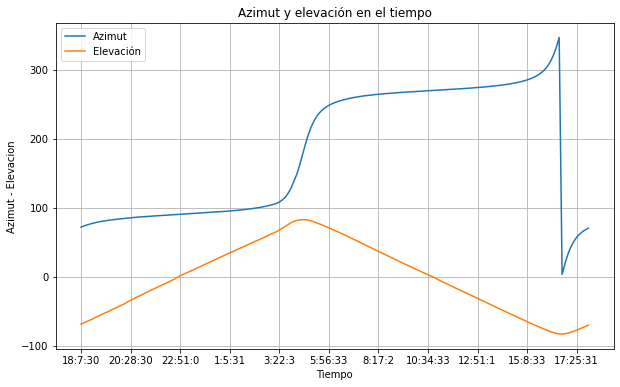

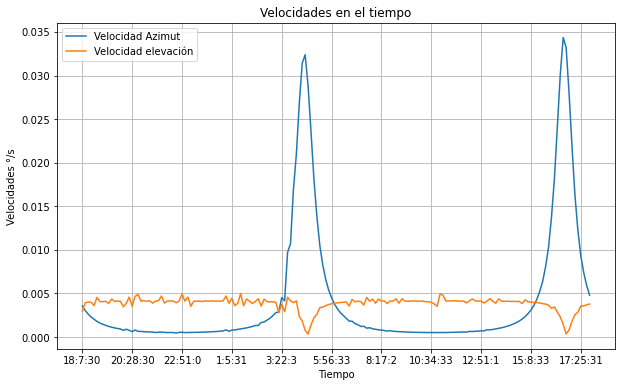

In [17]:
#Grafica de posicion
xpos_stick = len(Astro_data["Hora"])
fig, ax = plt.subplots(figsize=(10,6))
azimut_plot = ax.plot(Astro_data["Hora"], Astro_data["azimut"],label="Azimut")
elevacion_plot = ax.plot(Astro_data["Hora"], Astro_data["elevacion"],label="Elevación")
ax.set_ylabel("Azimut - Elevacion")
ax.set_xlabel("Tiempo")
ax.set_title("Azimut y elevación en el tiempo")
xpos_values = ax.get_xticks()
newx_pos_values = [xpos_values[i] for i in range(0,xpos_stick,xpos_stick//10)]
ax.set_xticks(newx_pos_values)
ax.legend()
ax.grid(b=True)

#Grafica de velocidad
xvel_stick = len(Astronomic_data_vel["Hora"])
fig_vel, ax_vel = plt.subplots(figsize=(10,6))
velazim_plot = ax_vel.plot(Astronomic_data_vel["Hora"],Astronomic_data_vel["velocidad azimut"],label="Velocidad Azimut")
velalt_plot = ax_vel.plot(Astronomic_data_vel["Hora"],Astronomic_data_vel["velocidad altitud"],label ="Velocidad elevación")
ax_vel.set_ylabel("Velocidades °/s")
ax_vel.set_xlabel("Tiempo")
ax_vel.set_title("Velocidades en el tiempo")
xvel_values = ax_vel.get_xticks()
newx_vel_values = [xvel_values[i] for i in range(0,(xvel_stick//2)*2,xvel_stick//10)]
ax_vel.set_xticks(newx_vel_values)
ax_vel.legend()
ax_vel.grid(b=True)
#Astronomic_data_vel.plot()



In [18]:
#Valores promedio, máx y min de velocidad en el eje del azimut
Velocidades_azimut = [
    Astronomic_data_vel["velocidad azimut"].mean(),
    Astronomic_data_vel["velocidad azimut"].max(),
     Astronomic_data_vel["velocidad azimut"].min()
]
Velocidades_elevacion = [
    Astronomic_data_vel["velocidad altitud"].mean(),
    Astronomic_data_vel["velocidad altitud"].max(),
    Astronomic_data_vel["velocidad altitud"].min(),
]
print("Valores promedio, max y min de velocidad en el eje de azimut")
print(Velocidades_azimut)
print("Valores promedio, max y min de velocidad en el eje de elevacion")
print(Velocidades_elevacion)


Valores promedio, max y min de velocidad en el eje de azimut
[0.0041553673861102315, 0.03436274944721639, 0.00046460801127904143]
Valores promedio, max y min de velocidad en el eje de elevacion
[0.0038514867498842175, 0.005002837900087811, 0.00035735600770381195]


In [19]:
#Se guardan los datos del seguimiento en un archivo .csv

#Datos de posición como vectores numpy
data_azim_csv = Astro_data["azimut"].to_numpy(copy = True)
data_elev_csv = Astro_data["elevacion"].to_numpy(copy= True)
data_date_csv = Astro_data["Date"].to_numpy(copy= True)
data_hour_csv = Astro_data["Hora"].to_numpy(copy= True)

#Datos de velocidad como vectores numpy
data_velazim_csv = Astronomic_data_vel["velocidad azimut"].to_numpy(copy = True)
data_velelev_csv = Astronomic_data_vel["velocidad altitud"].to_numpy(copy = True)

data_csv = pd.DataFrame(list(
zip(
    data_date_csv,
    data_hour_csv,
    data_azim_csv,
    data_elev_csv,
    data_velazim_csv,
    data_velelev_csv,
)),
columns=[
    "Fecha",
    "Hora",
    "Azimut",
    "Elevación",
    "Velocidad Azimut",
    "Velocidad Elevación"
])
#Cambiar el data por el nombre de la estrella que se siguió

data_csv.to_csv('16_Sadalmelik.csv',sep = ',',index = False)